# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import time

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

import plotly.graph_objects as go

In [4]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    # roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    roc_auc = roc_auc_score(y_test, y_pred)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [5]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [6]:
train = pd.read_parquet('./dataset/train_temp.parquet.gzip') 
test = pd.read_parquet('./dataset/test_temp.parquet.gzip') 

In [7]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']

In [8]:
train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp,well,target
7365884,0.0,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0,2014-01-24 09:33:03,WELL-00001,1
7365885,0.0,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0,2014-01-24 09:33:04,WELL-00001,1
7365886,0.0,18433410.0,116.8718,9397032.0,74.80031,-300917.8,0.0,2014-01-24 09:33:05,WELL-00001,1
7365887,0.0,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0,2014-01-24 09:33:06,WELL-00001,1
7365888,0.0,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0,2014-01-24 09:33:07,WELL-00001,1


## Models

In [9]:
with open('./models/pipeline_iForest.pkl', 'rb') as f:
    iforest = pickle.load(f) 

with open('./models/pipeline_PCA.pkl', 'rb') as f:
    pca = pickle.load(f) 

with open('./models/pipeline_LODA.pkl', 'rb') as f:
    loda = pickle.load(f) 

with open('./models/pipeline_SGDOSVM.pkl', 'rb') as f:
    sgdocsvm = pickle.load(f) 

In [10]:
iforest

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 IsolationForest(contamination=0.01, max_features=0.7,
                                 n_estimators=256, random_state=42))])

In [11]:
y_pred = iforest.predict(test[VARS])
test['iForest'] = np.where(y_pred == -1, 1, 0)  

y_pred = sgdocsvm.predict(test[VARS])
test['OCSVM'] = np.where(y_pred == -1, 1, 0)  

test['PCA'] = pca.predict(test[VARS])

test['LODA'] = loda.predict(test[VARS])

In [12]:
y_pred = iforest.predict(train[VARS])
train['iForest'] = np.where(y_pred == -1, 1, 0)  

y_pred = sgdocsvm.predict(train[VARS])
train['OCSVM'] = np.where(y_pred == -1, 1, 0)  

train['PCA'] = pca.predict(train[VARS])

train['LODA'] = loda.predict(train[VARS])

In [13]:
test['scores_iforest']=-iforest.decision_function(test[VARS])

test['scores_pca']=pca.decision_function(test[VARS])

test['scores_loda']=loda.decision_function(test[VARS])

test['scores_ocsvm']=-sgdocsvm.decision_function(test[VARS])

In [14]:
train['scores_iforest']=-iforest.decision_function(train[VARS])

train['scores_pca']=pca.decision_function(train[VARS])

train['scores_loda']=loda.decision_function(train[VARS])

train['scores_ocsvm']=-sgdocsvm.decision_function(train[VARS])

Classification Report: 
               precision    recall  f1-score   support

           0    0.87907   0.99033   0.93138   1493608
           1    0.97320   0.72055   0.82803    728192

    accuracy                        0.90191   2221800
   macro avg    0.92613   0.85544   0.87971   2221800
weighted avg    0.90992   0.90191   0.89751   2221800

Specificity: 0.9903254401422595
Gini:  0.7108799092932527
ROC AUC::  0.8554399546466264


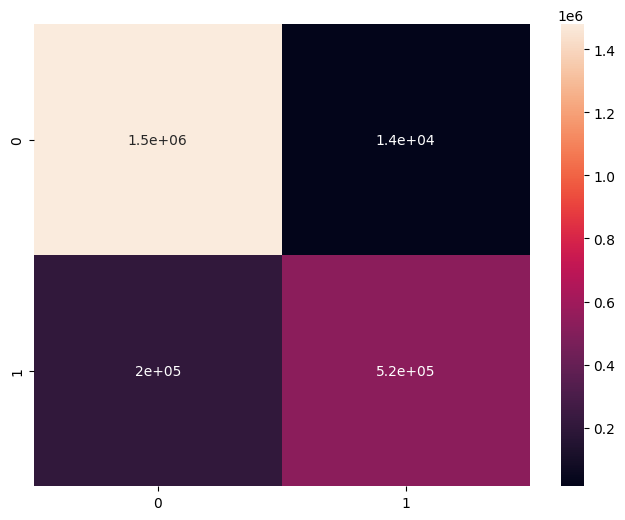

In [15]:
metrics(test.target, test.iForest)

Classification Report: 
               precision    recall  f1-score   support

           0    1.00000   0.99021   0.99508   1493608
           1    0.98032   1.00000   0.99006    728192

    accuracy                        0.99342   2221800
   macro avg    0.99016   0.99511   0.99257   2221800
weighted avg    0.99355   0.99342   0.99344   2221800

Specificity: 0.9902102827515653
Gini:  0.9902102827515653
ROC AUC::  0.9951051413757827


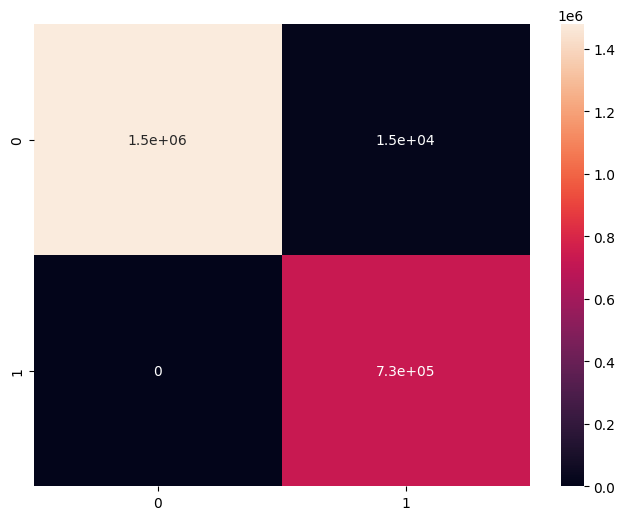

In [16]:
metrics(test.target, test.PCA)

Classification Report: 
               precision    recall  f1-score   support

           0    1.00000   0.98263   0.99124   1493608
           1    0.96560   1.00000   0.98250    728192

    accuracy                        0.98833   2221800
   macro avg    0.98280   0.99132   0.98687   2221800
weighted avg    0.98873   0.98833   0.98838   2221800

Specificity: 0.9826333281557142
Gini:  0.9826333281557142
ROC AUC::  0.9913166640778571


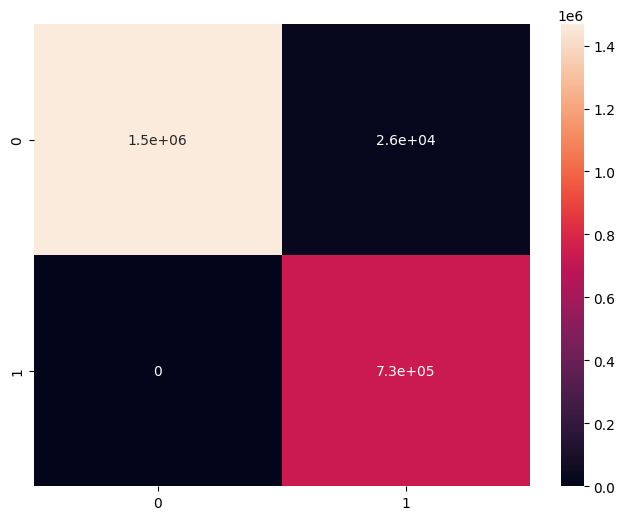

In [17]:
metrics(test.target, test.LODA)

Classification Report: 
               precision    recall  f1-score   support

           0    1.00000   0.86369   0.92686   1493608
           1    0.78150   1.00000   0.87735    728192

    accuracy                        0.90836   2221800
   macro avg    0.89075   0.93184   0.90211   2221800
weighted avg    0.92839   0.90836   0.91063   2221800

Specificity: 0.8636891339628604
Gini:  0.8636891339628603
ROC AUC::  0.9318445669814301


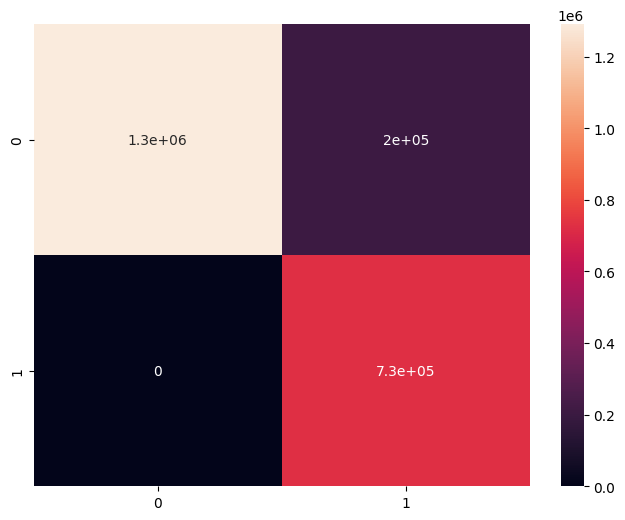

In [18]:
metrics(test.target, test.OCSVM)

train

Classification Report: 
               precision    recall  f1-score   support

           0    0.89587   0.99000   0.94059   5872276
           1    0.97552   0.77587   0.86432   3014901

    accuracy                        0.91736   8887177
   macro avg    0.93569   0.88294   0.90245   8887177
weighted avg    0.92289   0.91736   0.91471   8887177

Specificity: 0.99000268379756
Gini:  0.7658765847979576
ROC AUC::  0.8829382923989788


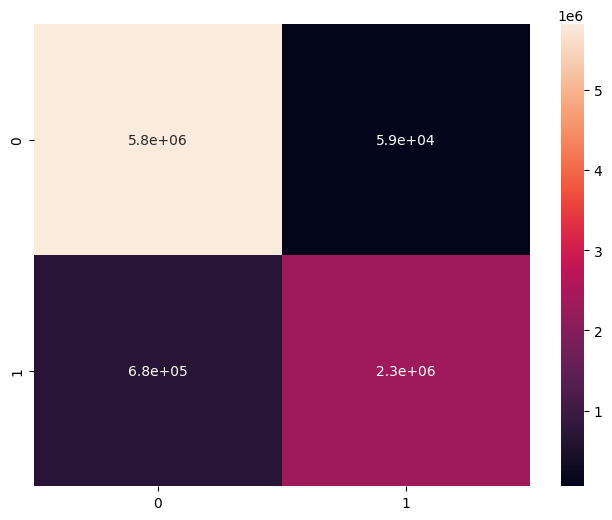

In [19]:
metrics(train.target, train.iForest)

Classification Report: 
               precision    recall  f1-score   support

           0    0.83793   0.99900   0.91140   5872276
           1    0.99689   0.62365   0.76729   3014901

    accuracy                        0.87167   8887177
   macro avg    0.91741   0.81133   0.83935   8887177
weighted avg    0.89186   0.87167   0.86251   8887177

Specificity: 0.9989998767087923
Gini:  0.6226538540699065
ROC AUC::  0.8113269270349532


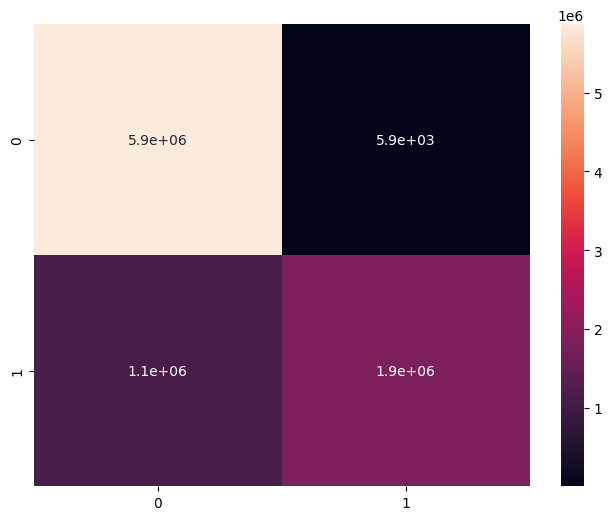

In [20]:
metrics(train.target, train.PCA)

Classification Report: 
               precision    recall  f1-score   support

           0    0.95467   0.99900   0.97633   5872276
           1    0.99786   0.90760   0.95059   3014901

    accuracy                        0.96799   8887177
   macro avg    0.97626   0.95330   0.96346   8887177
weighted avg    0.96932   0.96799   0.96760   8887177

Specificity: 0.9989998767087923
Gini:  0.9066038079821575
ROC AUC::  0.9533019039910787


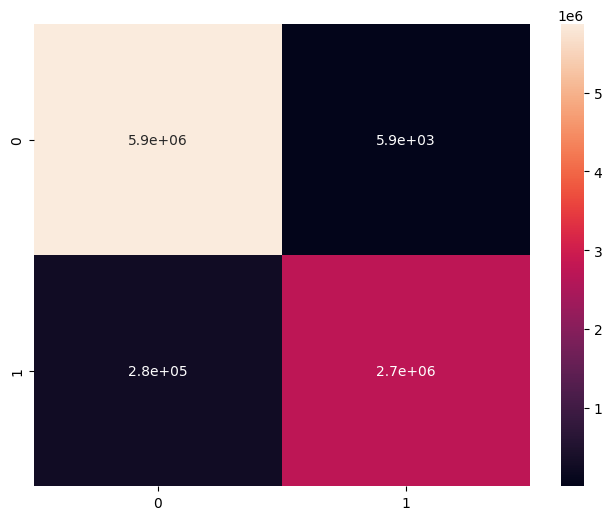

In [21]:
metrics(train.target, train.LODA)

Classification Report: 
               precision    recall  f1-score   support

           0    0.95577   0.99003   0.97260   5872276
           1    0.97912   0.91076   0.94370   3014901

    accuracy                        0.96314   8887177
   macro avg    0.96744   0.95039   0.95815   8887177
weighted avg    0.96369   0.96314   0.96279   8887177

Specificity: 0.9900277166808917
Gini:  0.9007846536416741
ROC AUC::  0.9503923268208371


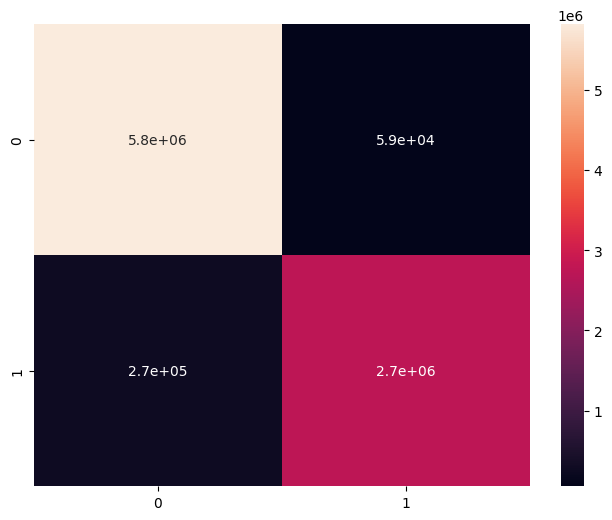

In [22]:
metrics(train.target, train.OCSVM)

In [23]:
 roc_auc_score(test.target, test.iForest)

0.8554399546466264

In [24]:
roc_auc_score(test.target, test.scores_iforest)

0.965188537350798

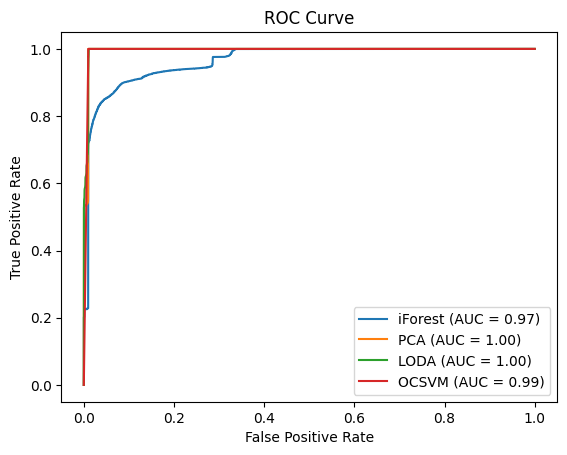

In [25]:

# Computar a taxa de verdadeiros positivos e a taxa de falsos positivos para cada modelo
fpr_model0, tpr_model0, _ = roc_curve(test.target, test.scores_iforest)
fpr_model1, tpr_model1, _ = roc_curve(test.target, test.scores_pca)
fpr_model2, tpr_model2, _ = roc_curve(test.target, test.scores_loda)
fpr_model3, tpr_model3, _ = roc_curve(test.target, test.scores_ocsvm)

# Calcular a pontuação AUC (área sob a curva) para cada modelo
roc_auc_model0 = roc_auc_score(test.target, test.scores_iforest)
roc_auc_model1 = roc_auc_score(test.target, test.scores_pca)
roc_auc_model2 = roc_auc_score(test.target, test.scores_loda)
roc_auc_model3 = roc_auc_score(test.target, test.scores_ocsvm)

# Plotar as curvas ROC para cada modelo
plt.plot(fpr_model0, tpr_model0, label='iForest (AUC = {0:0.2f})'.format(roc_auc_model0))
plt.plot(fpr_model1, tpr_model1, label='PCA (AUC = {0:0.2f})'.format(roc_auc_model1))
plt.plot(fpr_model2, tpr_model2, label='LODA (AUC = {0:0.2f})'.format(roc_auc_model2))
plt.plot(fpr_model3, tpr_model3, label='OCSVM (AUC = {0:0.2f})'.format(roc_auc_model3))

# Adicionar título e labels aos eixos
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


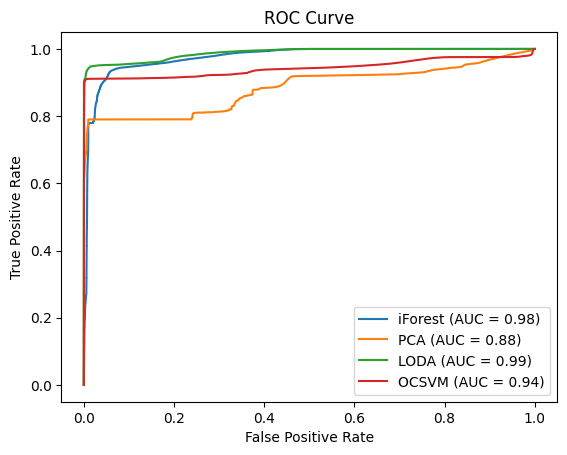

In [26]:
# Computar a taxa de verdadeiros positivos e a taxa de falsos positivos para cada modelo
fpr_model0, tpr_model0, _ = roc_curve(train.target, train.scores_iforest)
fpr_model1, tpr_model1, _ = roc_curve(train.target, train.scores_pca)
fpr_model2, tpr_model2, _ = roc_curve(train.target, train.scores_loda)
fpr_model3, tpr_model3, _ = roc_curve(train.target, train.scores_ocsvm)

# Calcular a pontuação AUC (área sob a curva) para cada modelo
roc_auc_model0 = roc_auc_score(train.target, train.scores_iforest)
roc_auc_model1 = roc_auc_score(train.target, train.scores_pca)
roc_auc_model2 = roc_auc_score(train.target, train.scores_loda)
roc_auc_model3 = roc_auc_score(train.target, train.scores_ocsvm)

# Plotar as curvas ROC para cada modelo
plt.plot(fpr_model0, tpr_model0, label='iForest (AUC = {0:0.2f})'.format(roc_auc_model0))
plt.plot(fpr_model1, tpr_model1, label='PCA (AUC = {0:0.2f})'.format(roc_auc_model1))
plt.plot(fpr_model2, tpr_model2, label='LODA (AUC = {0:0.2f})'.format(roc_auc_model2))
plt.plot(fpr_model3, tpr_model3, label='OCSVM (AUC = {0:0.2f})'.format(roc_auc_model3))

# Adicionar título e labels aos eixos
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

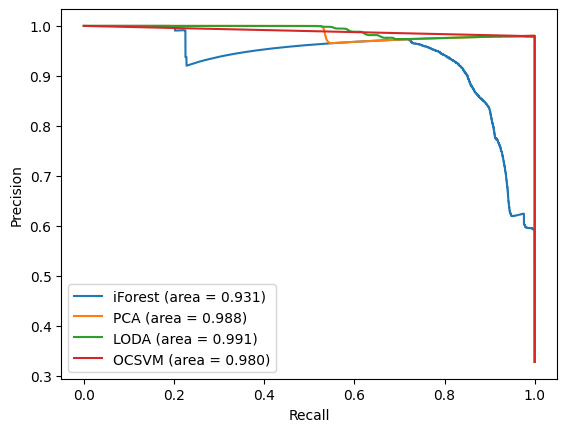

In [27]:
# Computar a precisão e o recall para cada modelo
precision_model0, recall_model0, _ = precision_recall_curve(test.target, test.scores_iforest)
precision_model1, recall_model1, _ = precision_recall_curve(test.target, test.scores_pca)
precision_model2, recall_model2, _ = precision_recall_curve(test.target, test.scores_loda)
precision_model3, recall_model3, _ = precision_recall_curve(test.target, test.scores_ocsvm)

# Calcular a pontuação de precisão média (AUC) para cada modelo
average_precision_model0 = average_precision_score(test.target, test.scores_iforest)
average_precision_model1 = average_precision_score(test.target, test.scores_pca)
average_precision_model2 = average_precision_score(test.target, test.scores_loda)
average_precision_model3 = average_precision_score(test.target, test.scores_ocsvm)

# Plotar as curvas de precisão-recall para cada modelo
plt.plot(recall_model0, precision_model0, label='iForest (area = {0:0.3f})'.format(average_precision_model0))
plt.plot(recall_model1, precision_model1, label='PCA (area = {0:0.3f})'.format(average_precision_model1))
plt.plot(recall_model2, precision_model2, label='LODA (area = {0:0.3f})'.format(average_precision_model2))
plt.plot(recall_model3, precision_model3, label='OCSVM (area = {0:0.3f})'.format(average_precision_model3))

# Adicionar título e labels aos eixos
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()

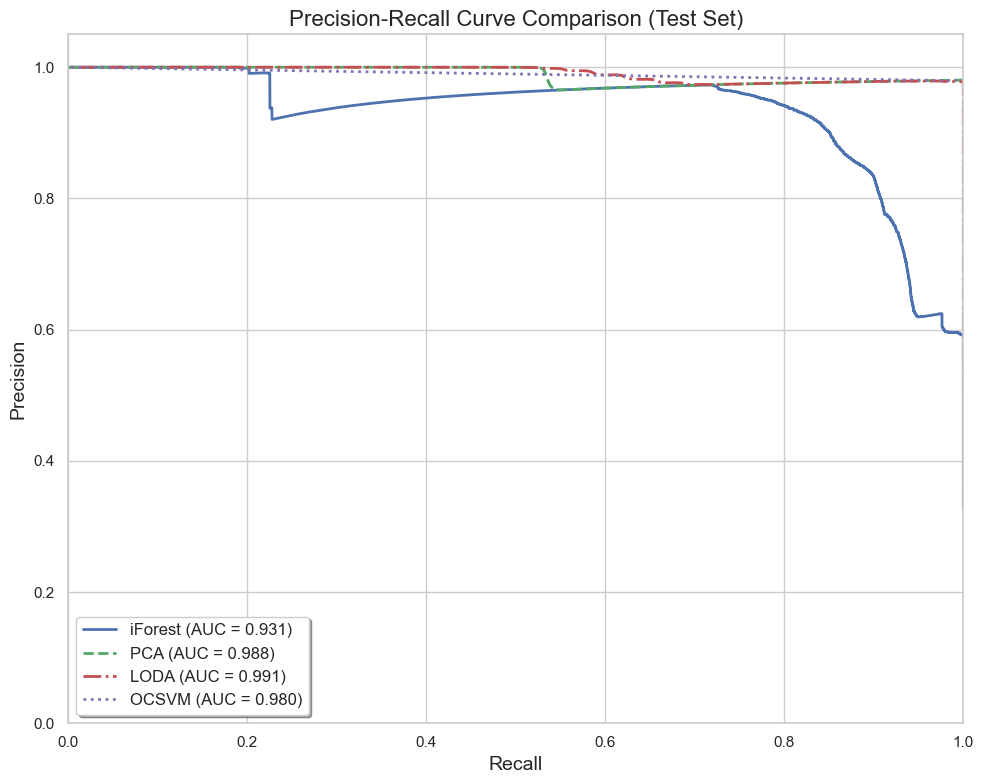

In [38]:
# Definir estilo para o gráfico
sns.set(style="whitegrid")

# Computar a precisão e o recall para cada modelo no conjunto de teste
precision_model0, recall_model0, _ = precision_recall_curve(test.target, test.scores_iforest)
precision_model1, recall_model1, _ = precision_recall_curve(test.target, test.scores_pca)
precision_model2, recall_model2, _ = precision_recall_curve(test.target, test.scores_loda)
precision_model3, recall_model3, _ = precision_recall_curve(test.target, test.scores_ocsvm)

# Calcular a pontuação de precisão média (AUC) para cada modelo
average_precision_model0 = average_precision_score(test.target, test.scores_iforest)
average_precision_model1 = average_precision_score(test.target, test.scores_pca)
average_precision_model2 = average_precision_score(test.target, test.scores_loda)
average_precision_model3 = average_precision_score(test.target, test.scores_ocsvm)

# Tamanho da figura
plt.figure(figsize=(10, 8))

# Plotar as curvas de precisão-recall com diferentes estilos
plt.plot(recall_model0, precision_model0, label='iForest (AUC = {0:0.3f})'.format(average_precision_model0), linestyle='-', color='b', linewidth=2)
plt.plot(recall_model1, precision_model1, label='PCA (AUC = {0:0.3f})'.format(average_precision_model1), linestyle='--', color='g', linewidth=2)
plt.plot(recall_model2, precision_model2, label='LODA (AUC = {0:0.3f})'.format(average_precision_model2), linestyle='-.', color='r', linewidth=2)
plt.plot(recall_model3, precision_model3, label='OCSVM (AUC = {0:0.3f})'.format(average_precision_model3), linestyle=':', color='m', linewidth=2)

# Adicionar título e rótulos
plt.title('Precision-Recall Curve Comparison (Test Set)', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)

# Limitar os eixos
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Melhorar a legenda
plt.legend(loc='lower left', fontsize=12, frameon=True, shadow=True)

# Adicionar grid para facilitar leitura
plt.grid(True)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

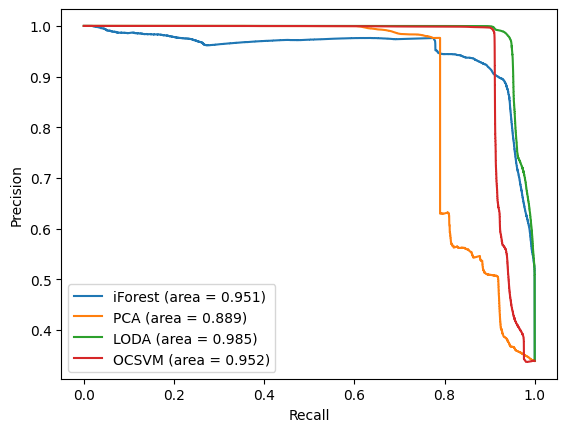

In [28]:
# Computar a precisão e o recall para cada modelo
precision_model0, recall_model0, _ = precision_recall_curve(train.target, train.scores_iforest)
precision_model1, recall_model1, _ = precision_recall_curve(train.target, train.scores_pca)
precision_model2, recall_model2, _ = precision_recall_curve(train.target, train.scores_loda)
precision_model3, recall_model3, _ = precision_recall_curve(train.target, train.scores_ocsvm)

# Calcular a pontuação de precisão média (AUC) para cada modelo
average_precision_model0 = average_precision_score(train.target, train.scores_iforest)
average_precision_model1 = average_precision_score(train.target, train.scores_pca)
average_precision_model2 = average_precision_score(train.target, train.scores_loda)
average_precision_model3 = average_precision_score(train.target, train.scores_ocsvm)

# Plotar as curvas de precisão-recall para cada modelo
plt.plot(recall_model0, precision_model0, label='iForest (area = {0:0.3f})'.format(average_precision_model0))
plt.plot(recall_model1, precision_model1, label='PCA (area = {0:0.3f})'.format(average_precision_model1))
plt.plot(recall_model2, precision_model2, label='LODA (area = {0:0.3f})'.format(average_precision_model2))
plt.plot(recall_model3, precision_model3, label='OCSVM (area = {0:0.3f})'.format(average_precision_model3))

# Adicionar título e labels aos eixos
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Precision-Recall curve')
plt.legend(loc='lower left')
plt.show()

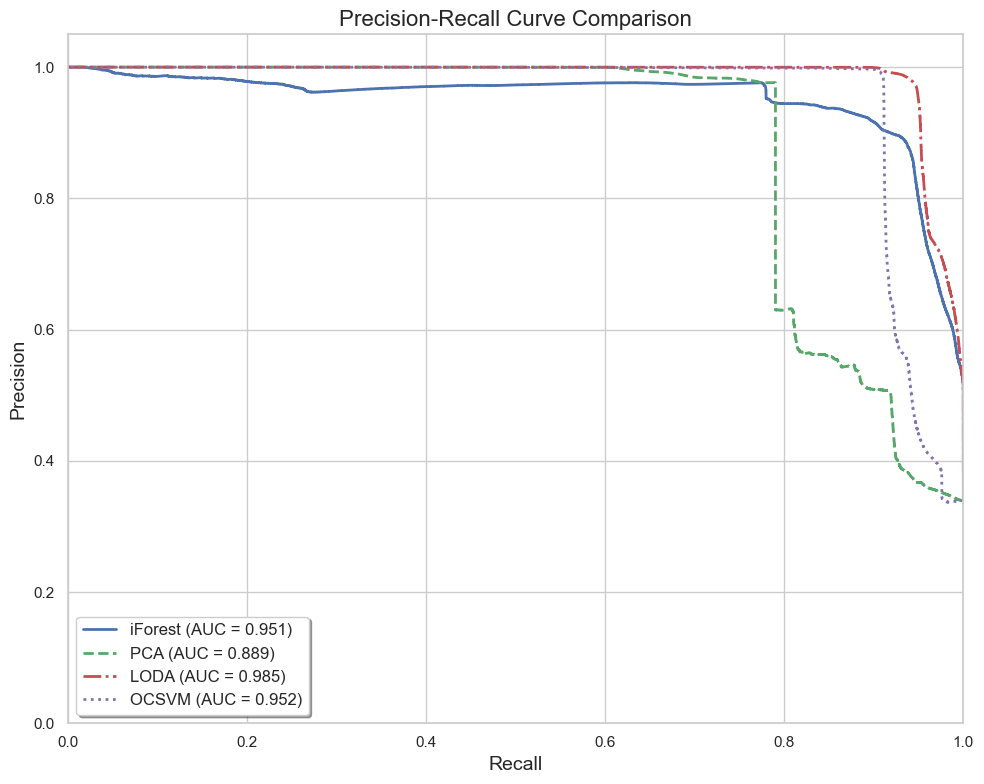

In [37]:
# Definir estilo para o gráfico
sns.set(style="whitegrid")

# Computar a precisão e o recall para cada modelo
precision_model0, recall_model0, _ = precision_recall_curve(train.target, train.scores_iforest)
precision_model1, recall_model1, _ = precision_recall_curve(train.target, train.scores_pca)
precision_model2, recall_model2, _ = precision_recall_curve(train.target, train.scores_loda)
precision_model3, recall_model3, _ = precision_recall_curve(train.target, train.scores_ocsvm)

# Calcular a pontuação de precisão média (AUC) para cada modelo
average_precision_model0 = average_precision_score(train.target, train.scores_iforest)
average_precision_model1 = average_precision_score(train.target, train.scores_pca)
average_precision_model2 = average_precision_score(train.target, train.scores_loda)
average_precision_model3 = average_precision_score(train.target, train.scores_ocsvm)

# Tamanho da figura
plt.figure(figsize=(10, 8))

# Plotar as curvas de precisão-recall com diferentes estilos
plt.plot(recall_model0, precision_model0, label='iForest (AUC = {0:0.3f})'.format(average_precision_model0), linestyle='-', color='b', linewidth=2)
plt.plot(recall_model1, precision_model1, label='PCA (AUC = {0:0.3f})'.format(average_precision_model1), linestyle='--', color='g', linewidth=2)
plt.plot(recall_model2, precision_model2, label='LODA (AUC = {0:0.3f})'.format(average_precision_model2), linestyle='-.', color='r', linewidth=2)
plt.plot(recall_model3, precision_model3, label='OCSVM (AUC = {0:0.3f})'.format(average_precision_model3), linestyle=':', color='m', linewidth=2)

# Adicionar título e rótulos
plt.title('Precision-Recall Curve Comparison', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)

# Limitar os eixos
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Melhorar a legenda
plt.legend(loc='lower left', fontsize=12, frameon=True, shadow=True)

# Adicionar grid para facilitar leitura
plt.grid(True)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


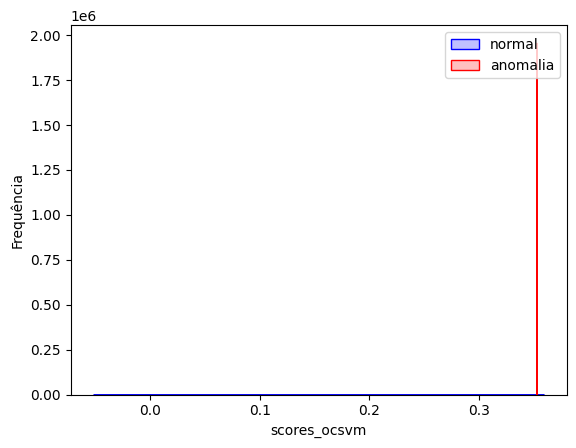

In [28]:
g = sns.kdeplot(test["scores_ocsvm"][(test["target"] == 0) & (test["scores_ocsvm"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(test["scores_ocsvm"][(test["target"] == 1) & (test["scores_ocsvm"].notnull())], ax =g, color="Red", fill= True)

g.set_xlabel("scores_ocsvm")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomalia'])

### Tempo de latência 

In [ ]:
# y_pred = iforest.predict(test[VARS])
# test['iForest'] = np.where(y_pred == -1, 1, 0)  

# y_pred = sgdocsvm.predict(test[VARS])
# test['OCSVM'] = np.where(y_pred == -1, 1, 0)  

# test['PCA'] = pca.predict(test[VARS])

# test['LODA'] = loda.predict(test[VARS])

In [29]:
import time

In [30]:
# Modelos de exemplo
models = {
    'IsolationForest': iforest,
    'PCA': pca,
    'LODA': loda,
    'OneClassSVM': sgdocsvm
}

In [31]:
# Função para calcular latência com simulação
def simulate_latency(model, X, n_simulations=100):
    latencies = []
    
    for _ in range(n_simulations):

        X_s = X.sample(n=1)

        start_time = time.time()
        model.predict(X_s)
        end_time = time.time()
        
        # Calcular a latência
        latencies.append(end_time - start_time)
    
    return np.mean(latencies), np.std(latencies)

n_simulations = 1000

for model_name, model in models.items():
    mean_latency, std_latency = simulate_latency(model, test[VARS], n_simulations=n_simulations)
    print(f"{model_name} - Latência média: {mean_latency:.6f} segundos, Desvio padrão: {std_latency:.6f} segundos")

IsolationForest - Latência média: 0.009415 segundos, Desvio padrão: 0.002912 segundos
PCA - Latência média: 0.002890 segundos, Desvio padrão: 0.003596 segundos
LODA - Latência média: 0.010308 segundos, Desvio padrão: 0.003972 segundos
OneClassSVM - Latência média: 0.003536 segundos, Desvio padrão: 0.001858 segundos


## TSNE

In [25]:
train_sample_tsne = train.sample(frac=0.002, random_state=48)
train_sample_tsne.shape

(17774, 18)

In [26]:
train_sample_tsne_transformed = iforest[1].transform((iforest[0].transform(train_sample_tsne[VARS])))

In [27]:
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=1000, n_jobs=-1)

In [28]:
X_reduce = tsne.fit_transform(train_sample_tsne_transformed)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17774 samples in 0.178s...
[t-SNE] Computed neighbors for 17774 samples in 0.923s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17774
[t-SNE] Computed conditional probabilities for sample 2000 / 17774
[t-SNE] Computed conditional probabilities for sample 3000 / 17774
[t-SNE] Computed conditional probabilities for sample 4000 / 17774
[t-SNE] Computed conditional probabilities for sample 5000 / 17774
[t-SNE] Computed conditional probabilities for sample 6000 / 17774
[t-SNE] Computed conditional probabilities for sample 7000 / 17774
[t-SNE] Computed conditional probabilities for sample 8000 / 17774
[t-SNE] Computed conditional probabilities for sample 9000 / 17774
[t-SNE] Computed conditional probabilities for sample 10000 / 17774
[t-SNE] Computed conditional probabilities for sample 11000 / 17774
[t-SNE] Computed conditional probabilities for sample 12000 / 17774
[t-SNE] Computed conditional probabilities for sam

In [29]:
tsne_result_df = pd.DataFrame({'tsne_1': X_reduce[:,0], 'tsne_2': X_reduce[:,1], 'tsne_3': X_reduce[:,0]})

tsne_result_df = tsne_result_df.reset_index(drop=True)
data_tsne = train_sample_tsne.reset_index(drop=True)

data_tsne = pd.concat([data_tsne, tsne_result_df], axis=1)
# data2= data2[data2['CONJUNTO']=='test']
data_tsne.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp,well,target,...,OCSVM,PCA,LODA,scores_iforest,scores_pca,scores_loda,scores_ocsvm,tsne_1,tsne_2,tsne_3
0,0.0,7692329.0,115.98580,1392323.0,71.00699,2332164.0,0.000000,2017-02-15 22:05:03,WELL-00002,0,...,0,0,0,-0.142402,4.934553e+02,0.013811,-0.019808,3.590950,-2.340828,3.590950
1,23428230.0,13984480.0,55.97573,2607340.0,37.41902,20036340.0,1.875875,2017-09-23 19:47:16,WELL-00014,1,...,1,1,1,0.048549,1.246269e+06,0.035102,0.352415,31.532644,-5.972567,31.532644
2,0.0,14229420.0,116.58940,6109810.0,69.11475,3007766.0,0.000000,2017-05-28 10:25:30,WELL-00001,0,...,0,0,0,-0.211279,2.984970e+02,0.011888,-0.021418,6.107171,-11.446284,6.107171
3,32308910.0,12881370.0,86.08977,5798349.0,30.51202,16627500.0,0.000000,2014-03-15 12:00:10,WELL-00017,1,...,1,1,1,0.042730,7.564139e+03,0.035490,0.352415,19.558762,4.912278,19.558762
4,23406160.0,13769710.0,56.46887,2372113.0,37.57725,19696220.0,1.503259,2017-09-15 21:14:52,WELL-00014,1,...,1,1,1,0.049346,9.987489e+05,0.035078,0.352415,24.816570,-16.530167,24.816570


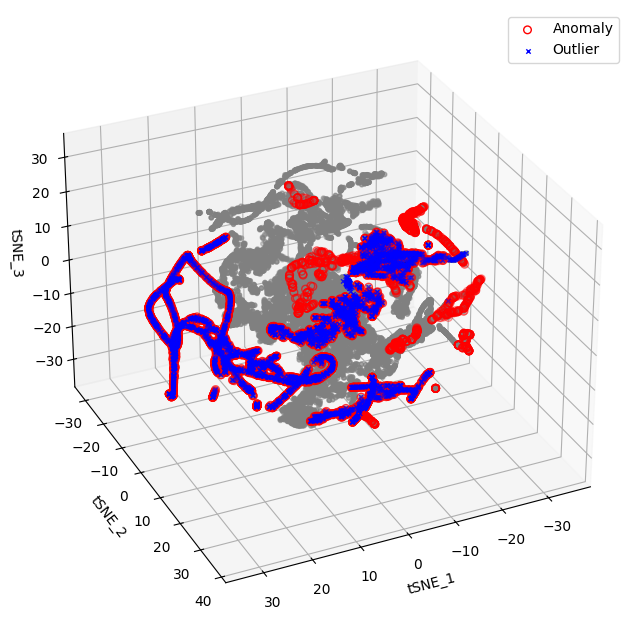

In [30]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("tSNE_3")
ax.set_ylabel("tSNE_2")
ax.set_xlabel("tSNE_1")

# Plot the reduced dimensionality data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=10, lw=1, c='grey')

# Plot circles around the predicted outliers
ax.scatter(X_reduce[data_tsne.target == 1, 0], X_reduce[data_tsne.target == 1, 1], zs=X_reduce[data_tsne.target == 1, 2],
           lw=1, facecolors="none", edgecolors="red", s=30, label="Anomaly")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[data_tsne.iForest == 1, 0], X_reduce[data_tsne.iForest == 1, 1], zs=X_reduce[data_tsne.iForest == 1, 2],
           lw=1, s=10, marker="x", c="blue", label="Outlier")

ax.legend()

# Rotacionar o gráfico
ax.view_init(elev=30, azim=65)  # Elevação e azimute em graus

plt.show()

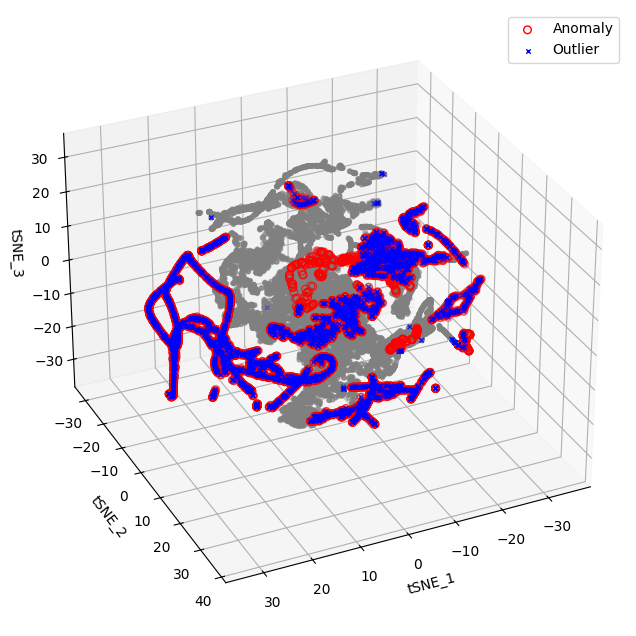

In [31]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("tSNE_3")
ax.set_ylabel("tSNE_2")
ax.set_xlabel("tSNE_1")

# Plot the reduced dimensionality data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=10, lw=1, c='grey')

# Plot circles around the predicted outliers
ax.scatter(X_reduce[data_tsne.target == 1, 0], X_reduce[data_tsne.target == 1, 1], zs=X_reduce[data_tsne.target == 1, 2],
           lw=1, facecolors="none", edgecolors="red", s=30, label="Anomaly")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[data_tsne.OCSVM == 1, 0], X_reduce[data_tsne.OCSVM == 1, 1], zs=X_reduce[data_tsne.OCSVM == 1, 2],
           lw=1, s=10, marker="x", c="blue", label="Outlier")

ax.legend()

# Rotacionar o gráfico
ax.view_init(elev=30, azim=65)  # Elevação e azimute em graus

plt.show()

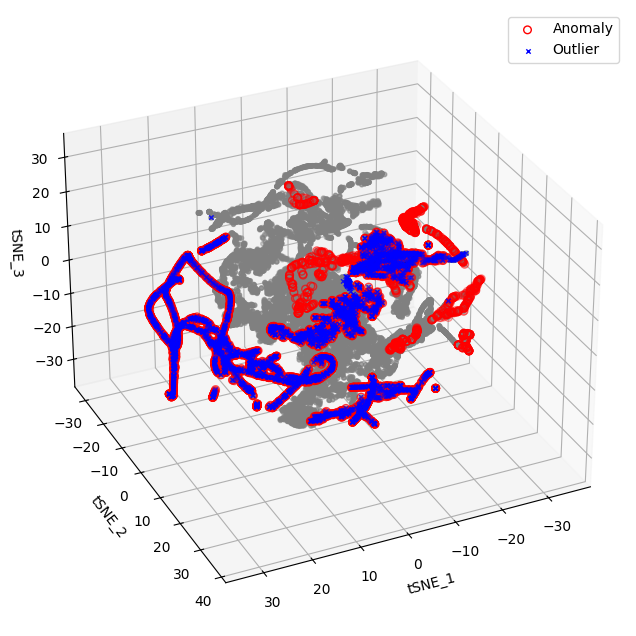

In [32]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("tSNE_3")
ax.set_ylabel("tSNE_2")
ax.set_xlabel("tSNE_1")

# Plot the reduced dimensionality data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=10, lw=1, c='grey')

# Plot circles around the predicted outliers
ax.scatter(X_reduce[data_tsne.target == 1, 0], X_reduce[data_tsne.target == 1, 1], zs=X_reduce[data_tsne.target == 1, 2],
           lw=1, facecolors="none", edgecolors="red", s=30, label="Anomaly")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[data_tsne.PCA == 1, 0], X_reduce[data_tsne.PCA == 1, 1], zs=X_reduce[data_tsne.PCA == 1, 2],
           lw=1, s=10, marker="x", c="blue", label="Outlier")

ax.legend()

# Rotacionar o gráfico
ax.view_init(elev=30, azim=65)  # Elevação e azimute em graus

plt.show()

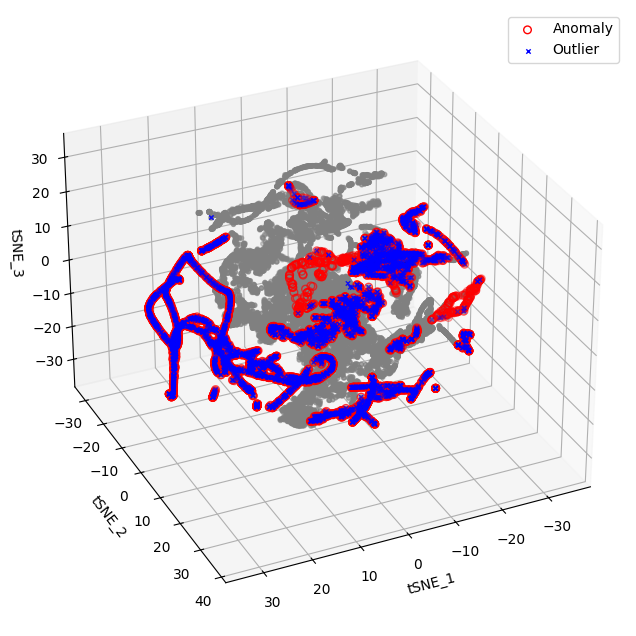

In [33]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("tSNE_3")
ax.set_ylabel("tSNE_2")
ax.set_xlabel("tSNE_1")

# Plot the reduced dimensionality data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=10, lw=1, c='grey')

# Plot circles around the predicted outliers
ax.scatter(X_reduce[data_tsne.target == 1, 0], X_reduce[data_tsne.target == 1, 1], zs=X_reduce[data_tsne.target == 1, 2],
           lw=1, facecolors="none", edgecolors="red", s=30, label="Anomaly")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[data_tsne.LODA == 1, 0], X_reduce[data_tsne.LODA == 1, 1], zs=X_reduce[data_tsne.LODA == 1, 2],
           lw=1, s=10, marker="x", c="blue", label="Outlier")

ax.legend()

# Rotacionar o gráfico
ax.view_init(elev=30, azim=65)  # Elevação e azimute em graus

plt.show()

### McNemar test

In [32]:
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import mcnemar_table

In [33]:
def test_hip(table):
    # calculate mcnemar test
    result = mcnemar(table, exact=True,  correction=True)
    # summarize the finding
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    # interpret the p-value
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')


def test_hip2(table):
    result = mcnemar(table, exact=True, correction=True)
    p = result.pvalue
    return np.float(p) 

In [34]:
test.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,timestamp,well,target,iForest,OCSVM,PCA,LODA,scores_iforest,scores_pca,scores_loda,scores_ocsvm
1239889,-6887865.0,9682304.0,118.4759,1873020.0,84.63268,-140331.8,0.0,2017-08-23 19:43:34,WELL-00001,0,0,1,0,0,-0.016383,98.275063,0.021731,0.001142
1239890,-6887865.0,9682139.0,118.4759,1881098.0,84.63499,-140331.8,0.0,2017-08-23 19:43:35,WELL-00001,0,0,1,0,0,-0.017473,98.255426,0.021749,0.001139
1239891,-6887865.0,9681974.0,118.4759,1889175.0,84.63731,-140331.8,0.0,2017-08-23 19:43:36,WELL-00001,0,0,1,0,0,-0.017473,98.235849,0.021651,0.001137
1239892,-6887865.0,9681809.0,118.4759,1897253.0,84.63963,-140331.8,0.0,2017-08-23 19:43:37,WELL-00001,0,0,1,0,0,-0.018961,98.216319,0.021668,0.001135
1239893,-6887865.0,9681644.0,118.4759,1905330.0,84.64195,-140331.8,0.0,2017-08-23 19:43:38,WELL-00001,0,0,1,0,0,-0.018602,98.196842,0.021685,0.001134


In [35]:
table1 = mcnemar_table(y_target=test.target, 
                   y_model1=test.iForest, 
                   y_model2=test.PCA)

table2 = mcnemar_table(y_target=test.target, 
                   y_model1=test.iForest, 
                   y_model2=test.LODA)

table3 = mcnemar_table(y_target=test.target, 
                   y_model1=test.iForest, 
                   y_model2=test.OCSVM)


table4 = mcnemar_table(y_target=test.target, 
                   y_model1=test.PCA, 
                   y_model2=test.LODA)


table5 = mcnemar_table(y_target=test.target, 
                   y_model1=test.PCA, 
                   y_model2=test.OCSVM)

table6 = mcnemar_table(y_target=test.target, 
                   y_model1=test.LODA, 
                   y_model2=test.OCSVM)



In [36]:
print('iForest vs PCA')
test_hip(table1)
print('iForest vs LODA')
test_hip(table2)
print('iForest vs OCSVM')
test_hip(table3)
print('PCA vs LODA')
test_hip(table4)
print('PCA vs OCSVM')
test_hip(table5)
print('LODA vs OCSVM')
test_hip(table6)

iForest vs PCA
statistic=252.000, p-value=0.000
Different proportions of errors (reject H0)
iForest vs LODA
statistic=11568.000, p-value=0.000
Different proportions of errors (reject H0)
iForest vs OCSVM
statistic=189159.000, p-value=0.000
Different proportions of errors (reject H0)
PCA vs LODA
statistic=175.000, p-value=0.000
Different proportions of errors (reject H0)
PCA vs OCSVM
statistic=0.000, p-value=0.000
Different proportions of errors (reject H0)
LODA vs OCSVM
statistic=10667.000, p-value=0.000
Different proportions of errors (reject H0)
